<font size="+3"><strong>Predicting Price with Size</strong></font>

In [ ]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import train_test_split

warnings.simplefilter(action="ignore", category=FutureWarning)

# **Prepare Data**

## **Import**

In [ ]:
def wrangle(filepath):
      # Import_csv
      df = pd.read_csv(filepath)

      # Subset data: Apartments in "Capital Federal", less than 400,000
      mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
      mask_apt = df["property_type"] == "apartment"
      mask_price = df["price_aprox_usd"] < 400_000
      df = df[mask_ba & mask_apt & mask_price]

      # Split "lat-lon" column
      df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
      df.drop(columns="lat-lon", inplace=True)

      # Drop features with high null counts
      df.drop(columns = ["floor","expenses"], inplace= True)

      # Drop low and high cardinality categorical variables
      df.drop(columns= ["operation", "property_type", "currency","properati_url"], inplace=True)

      # Drop Leakey columns
      df.drop(columns= [
          "price",
          "price_aprox_local_currency",
          "price_per_m2",
          "price_usd_per_m2"
           ],
      inplace= True)

      # Drop columns with multicollinearity
      df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)

      # Subset data: Remove outliers for "surface_covered_in_m2"
      low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
      mask_area = df["surface_covered_in_m2"].between(low, high)
      df = df[mask_area]

      # Get place name
      df["neighborhood"] = df["place_with_parent_names"].str.split("|",expand=True)[3]
      df.drop(columns="place_with_parent_names", inplace=True)

      return df

In [ ]:
# Create a list that contains the filenames for all real estate CSV files
files = glob("buenos-aires-real-estate-*.csv")

# Use the wrangle function in a for loop to create a list named frames
frames = []
for file in files:
   df= wrangle(file)
   frames.append(df)

# Use `pd.concat` to concatenate the items in frames into a single DataFrame `df`
df = pd.concat(frames, ignore_index= True)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,112000.0,60.0,-34.564676,-58.455720,Belgrano
1,76500.0,36.0,-34.618830,-58.437779,Caballito
2,90000.0,100.0,-34.577168,-58.538654,Belgrano
3,159900.0,77.0,-34.571526,-58.455637,Colegiales
4,123875.0,50.0,-34.578688,-58.457358,Colegiales


## **Explore**

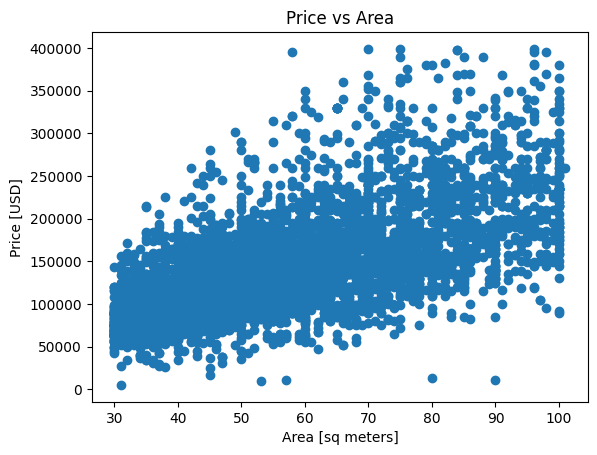

In [ ]:
# Exploring the relationship between apartment size and price
plt.scatter(x= df["surface_covered_in_m2"], y= df["price_aprox_usd"])
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Price vs Area");

## **Split**

In [ ]:
# Create feature matrix and target vector
features = ["surface_covered_in_m2"]
target = "price_aprox_usd"
y = df[target]
X = df[features]
print(X.shape)
print(y.shape)

(6582, 1)
(6582,)


In [ ]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5265, 1)
y_train shape: (5265,)
X_test shape: (1317, 1)
y_test shape: (1317,)


# **Build Model**

## **Baseline**

In [ ]:
# Calculate the mean of the target vector
y_mean = y_train.mean()
y_mean

132015.1484482431

In [ ]:
# Generate a list that repeats the prediction for every observation in our dataset
y_pred_baseline = [y_mean] * len(y_train)
y_pred_baseline[:5]

[132015.1484482431,
 132015.1484482431,
 132015.1484482431,
 132015.1484482431,
 132015.1484482431]

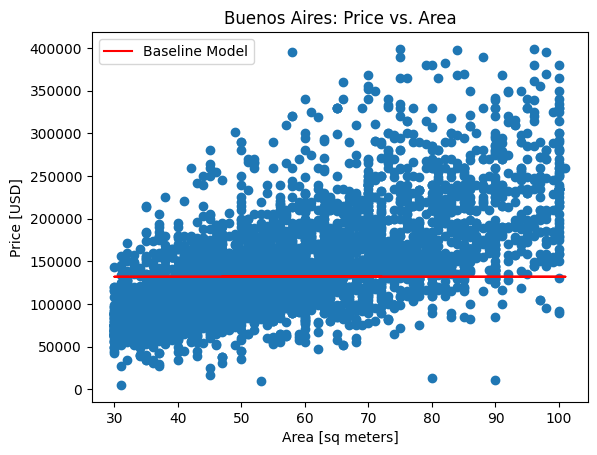

In [ ]:
# plotting the baseline model
plt.plot(X_train, y_pred_baseline, color="red", label="Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.legend();

In [ ]:
# Calculate the baseline mean absolute error
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 132015.15
Baseline MAE: 44393.95


## **Iterate**

In [ ]:
# Instantiate a `LinearRegression` model
model = LinearRegression()

In [ ]:
# Fit the model
model.fit(X_train, y_train)

LinearRegression()

## **Evaluate**

In [ ]:
# Create a list of predictions
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([172532.64780511, 119255.8759812 ,  92617.49006925,  81518.16260594,
       117036.01048854])

In [ ]:
# Calculate the training mean absolute error
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 30396.72


In [ ]:
r2_square_train = metrics.r2_score(y_train, y_pred_training)
r2_square_train

0.47273376359897945

In [ ]:
# Calculate the testing mean absolute error
y_pred_test = pd.Series(model.predict(X_test))
print(y_pred_test.head())
mae_testing = mean_absolute_error(y_test, y_pred_test)
print("Testing MAE:", round(mae_testing, 2))

0    199171.033717
1    105936.683025
2    154773.723864
3     97057.221055
4    148114.127386
dtype: float64
Testing MAE: 30633.42


In [ ]:
r2_square_test = metrics.r2_score(y_test, y_pred_test)
r2_square_test

0.4960535211957744

# **Communicate Results**

In [ ]:
# Extract the intercept from the model
intercept = round(model.intercept_, 2)
print("Model Intercept:", intercept)

Model Intercept: 12702.33


In [ ]:
# Extract the coefficient associated `"surface_covered_in_m2"` in the model
coefficient = round(model.coef_[0], 2)
print('Model coefficient for "surface_covered_in_m2":', coefficient)

Model coefficient for "surface_covered_in_m2": 2219.87


In [ ]:
# Print the equation that the model has determined for predicting
print(f"Apartment_price = {intercept} + {coefficient} * surface_covered_in_m2")

Apartment_price = 12702.33 + 2219.87 * surface_covered_in_m2


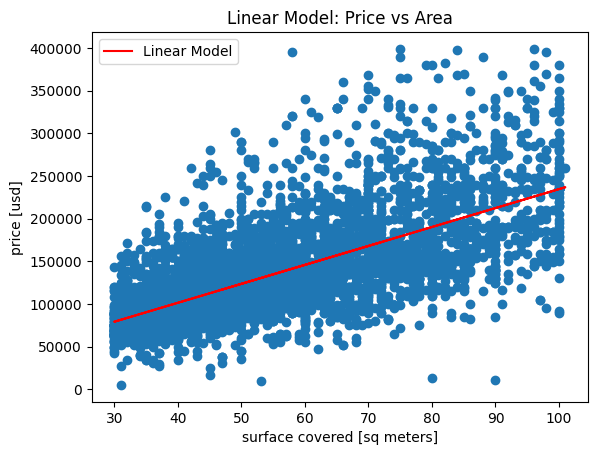

In [ ]:
# The relationship between the observations in `X_train` and the model’s predictions
plt.plot(X_train, y_pred_training, color="red", label="Linear Model")
plt.scatter(X_train, y_train)
plt.xlabel("surface covered [sq meters]")
plt.ylabel("price [usd]")
plt.title("Linear Model: Price vs Area")
plt.legend();